In [ ]:
!wget https://sagemaker-us-east-2-989469581176.s3.us-east-2.amazonaws.com/img.zip

--2020-11-29 06:54:32--  https://sagemaker-us-east-2-989469581176.s3.us-east-2.amazonaws.com/img.zip
Resolving sagemaker-us-east-2-989469581176.s3.us-east-2.amazonaws.com (sagemaker-us-east-2-989469581176.s3.us-east-2.amazonaws.com)... 52.219.105.186
Connecting to sagemaker-us-east-2-989469581176.s3.us-east-2.amazonaws.com (sagemaker-us-east-2-989469581176.s3.us-east-2.amazonaws.com)|52.219.105.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3604281615 (3.4G) [application/zip]
Saving to: ‘img.zip’

img.zip             100%[===================>]   3.36G  53.6MB/s    in 41s     

2020-11-29 06:55:14 (83.8 MB/s) - ‘img.zip’ saved [3604281615/3604281615]



In [2]:
!wget https://github.com/dvlprguy/reddit-depression-analysis/raw/main/preproc_data.csv

--2020-11-29 07:00:39--  https://github.com/dvlprguy/reddit-depression-analysis/raw/main/preproc_data.csv
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dvlprguy/reddit-depression-analysis/main/preproc_data.csv [following]
--2020-11-29 07:00:40--  https://raw.githubusercontent.com/dvlprguy/reddit-depression-analysis/main/preproc_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 707293 (691K) [text/plain]
Saving to: ‘preproc_data.csv’

preproc_data.csv    100%[===================>] 690.72K  --.-KB/s    in 0.03s   

2020-11-29 07:00:40 (23.1 MB/s) - ‘preproc_data.csv’ saved [707293/707293]


In [3]:
!unzip img.zip

Streaming output truncated to the last 5000 lines.
  inflating: img/13450.png           
  inflating: __MACOSX/img/._13450.png  
  inflating: img/04138.png           
  inflating: __MACOSX/img/._04138.png  
  inflating: img/49038.png           
  inflating: __MACOSX/img/._49038.png  
  inflating: img/07431.png           
  inflating: __MACOSX/img/._07431.png  
  inflating: img/47015.png           
  inflating: __MACOSX/img/._47015.png  
  inflating: img/48326.png           
  inflating: __MACOSX/img/._48326.png  
  inflating: img/01726.png           
  inflating: __MACOSX/img/._01726.png  
  inflating: img/79845.png           
  inflating: __MACOSX/img/._79845.png  
  inflating: img/37294.png           
  inflating: __MACOSX/img/._37294.png  
  inflating: img/85426.png           
  inflating: __MACOSX/img/._85426.png  
  inflating: img/91453.png           
  inflating: __MACOSX/img/._91453.png  
  inflating: img/72910.png           
  inflating: __MACOSX/img/._72910.png  
  inflating: 

In [1]:
import pandas as pd
# import numpy as np

In [2]:
df=pd.read_csv("preproc_data.csv")
df.head()

,id,img,label,text
0,74832,img/74832.png,0,if your man dresses like this there no doubt h...
1,51397,img/51397.png,0,when you catch your goat with another man ya d...
2,63871,img/63871.png,0,you can be any gender you want if you are ment...
3,18529,img/18529.png,1,shoot them
4,72951,img/72951.png,0,october this year i am going to get through no...


In [3]:
df.isna().any()

id       False
img      False
label    False
text      True
dtype: bool

In [4]:
df.fillna("dummy text",inplace=True)

In [5]:
import matplotlib.pyplot as plt
import cv2
def img_plotter():
  fig,ax = plt.subplots(5,5,figsize=(30,30))
  
  for i in range(5):
    for j in range(5):
      b,g,r = cv2.split(cv2.imread(df["img"].values[5*i+j]))
      ax[i,j].imshow(cv2.merge([r,g,b]))

In [6]:
# img_plotter()

In [7]:
%%capture
!pip install transformers

In [8]:
from transformers import BertTokenizer,BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert = BertModel.from_pretrained('bert-base-uncased')

In [9]:
import numpy as np
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import torch
import cv2
from keras_preprocessing.sequence  import pad_sequences

class Meme_Dataset(Dataset):
  def __init__(self,csv,transforms=None):
    self.csv = csv
    
    self.transforms = transforms
  
  def __len__(self):
    return len(self.csv)
  
  def __getitem__(self,idx):
    if torch.is_tensor(idx):
      idx.to_list()
    req = self.csv.iloc[idx]
    img_name = req.img
    img_label = [req.label]
    text = req.text
    encoding = tokenizer.encode(text)
    encoding = pad_sequences([encoding],maxlen=40,padding="post")
    mask = encoding.copy()
    mask[mask>0] = 1
    img = cv2.imread(img_name)
    if self.transforms:
      img = self.transforms(img)

    sample = {"image":img,"label":torch.FloatTensor(img_label),"text":text,"embeddings":torch.LongTensor(encoding),"attn":torch.FloatTensor(mask)}
    
    return sample


In [10]:
train_transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize((255,255)),transforms.CenterCrop(224),transforms.ToTensor(),transforms.RandomHorizontalFlip(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
valid_transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize((255,255)),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [11]:
from sklearn.model_selection import train_test_split
train_df,valid_df=train_test_split(df,test_size=0.2,stratify=df['label'],random_state=42,shuffle=True)

In [12]:
from collections import Counter
print(Counter(train_df['label']))
print(Counter(valid_df['label']))

Counter({0: 4355, 1: 2434})
Counter({0: 1089, 1: 609})


In [13]:
train_dataset=Meme_Dataset(train_df,transforms=train_transform)
valid_dataset=Meme_Dataset(valid_df,transforms=valid_transform)

In [14]:
train_dataloader=DataLoader(train_dataset,shuffle=True,batch_size=32)
valid_dataloader=DataLoader(valid_dataset,shuffle=True,batch_size=32)

In [15]:
import torch.nn as nn
import torch.nn.functional as F
class Convpart(nn.Module):
  def __init__(self):
    super(Convpart,self).__init__()

    self.cnn1 = nn.Sequential(nn.Conv2d(3,128,kernel_size=5,padding=2),
                                nn.Conv2d(128,64,kernel_size=5,padding=2),
                                nn.AvgPool2d(kernel_size=3,padding=1))
    self.cnn2 = nn.Sequential(nn.Conv2d(64,64,kernel_size=5,padding=2),
                                nn.Conv2d(64,32,kernel_size=5,padding=2),
                                nn.MaxPool2d(kernel_size=3,padding=1))
    self.dropout = nn.Dropout(0.7)
    self.cnn3 = nn.Sequential(nn.Conv2d(32,32,kernel_size=5,padding=2),
                                nn.Conv2d(32,32,kernel_size=5,padding=2),
                                nn.MaxPool2d(kernel_size=3,padding=1))
    self.flat = nn.Flatten()
    self.fc1 = nn.Linear(2592,1500)
    
    self.fc2 = nn.Linear(1500,1000)
    
    self.fc3 = nn.Linear(1000,768)
    self.flat = nn.Flatten()

  def forward(self,x):
    x = F.relu(self.cnn1(x),inplace=False)
    x = F.relu(self.cnn2(x),inplace=False)
    x = F.relu(self.dropout(self.cnn3(x)),inplace=False)
    x = self.flat(x)
    x = F.relu(self.fc1(x),inplace=False)
    x = F.relu(self.fc2(x),inplace=False)
    out = self.flat(F.relu(self.fc3(x)))

    return out

In [16]:
from torchvision.models import vgg16,resnet50,mobilenet_v2
vgg = vgg16(pretrained=True)
resnet = resnet50(pretrained=True)
mobilenet = mobilenet_v2(pretrained=True)

In [17]:
class VGG_Part(nn.Module):
  def __init__(self):
    super(VGG_Part,self).__init__()
    self.model = torch.nn.Sequential(*(list(vgg.children())[:-1]))
    self.pooling = torch.nn.MaxPool2d(kernel_size=3)
    self.flat_layer = nn.Flatten()
    #self.fc = nn.Linear(512*7*7,768)

  def forward(self,x):
    x = self.model(x)
    #print("VGG: ",x.size())
    x = self.pooling(x)
    out = self.flat_layer(x)
    # print("vgg",out.size())
    #out = self.
    return out

In [18]:
class Resnet_Part(nn.Module):
  def __init__(self):
    super(Resnet_Part,self).__init__()
    self.model = torch.nn.Sequential(*(list(resnet.children())[:-1]))
    self.pooling = torch.nn.MaxPool2d(kernel_size=3)
    self.flat_layer = nn.Flatten()
    #self.fc = nn.Linear(512*7*7,768)
  def forward(self,x):
    x = self.model(x)
    #print("Resnet: ",x.size())
    #x = self.pooling(x)
    out = self.flat_layer(x)
    # print("resnet",out.size())
    #out = self.
    return out

In [19]:
class MobileNet_Part(nn.Module):
  def __init__(self):
    super(MobileNet_Part,self).__init__()
    self.model = torch.nn.Sequential(*(list(mobilenet.children())[:-1]))
    self.pooling = torch.nn.MaxPool2d(kernel_size=3)
    self.flat_layer = nn.Flatten()
    #self.fc = nn.Linear(512*7*7,768)

  def forward(self,x):
    x = self.model(x)
    #print("Mobile Net: ",x.size())
    x = self.pooling(x)
    out = self.flat_layer(x)
    #out = self.
    return out

In [20]:
class Ensemble_Block(nn.Module):
  def __init__(self):
    super(Ensemble_Block,self).__init__()
    self.vgg = VGG_Part()
    self.res= Resnet_Part()
    self.mobile = MobileNet_Part()
    self.fc_b1 = nn.Sequential(nn.Linear(9216,6000),
                               nn.BatchNorm1d(6000))
    self.d1 = nn.Dropout(0.6)
    self.fc_b2 = nn.Sequential(nn.Linear(6000,3000),
                               nn.BatchNorm1d(3000))
    self.d2 = nn.Dropout(0.6)
    self.fc3 = nn.Linear(3000,768)

  def forward(self,x):
    x1 = self.vgg(x)
    x2 = self.res(x)
    x3 = self.mobile(x)
    # print(x1.size())
    # print(x2.size())
    # print(x3.size())
    out_1 = torch.cat([x1,x2,x3],dim=1)
    # print("O1: ",out_1.size())
    out_1 = self.d1(self.fc_b1(out_1))
    out_1 = self.d2(self.fc_b2(out_1))
    out = self.fc3(out_1)
    return out


In [21]:
class BERTpart(nn.Module):
  def __init__(self):
    super(BERTpart,self).__init__()
    #self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    self.model = BertModel.from_pretrained('bert-base-uncased')
    self.pooling = nn.AvgPool1d(kernel_size=3)
    self.flat_layer = nn.Flatten()
    self.dropout = nn.Dropout(0.6)
    #self.fc1 = nn.Linear(5120,8000)
    #self.fc2 = nn.Linear(8000,3000)
    self.fc3 = nn.Linear(10240,768)
  def forward(self,x,attn):
    #tokens = self.tokenizer.encode(x)
    #tokens = torch.FloatTensor(tokens)
    x =  self.model(input_ids=x.squeeze(1),encoder_attention_mask=attn)[0]
    #x = x.squeeze(1)
    #x = self.model(input_ids=x)
    x = self.pooling(x)
    x = self.flat_layer(x)
    # print(x.size())
    
    #x = F.relu(self.fc1(x),inplace=False)
    #x = F.relu(self.dropout(self.fc2(x)),inplace=False)

    out = F.relu(self.fc3(x),inplace=False)
    return out


In [22]:
class MemeNet(nn.Module):
  def __init__(self):
    super(MemeNet,self).__init__()
    #self.vgg_part = VGG_Part()
    #self.conv_part = Convpart()
    self.bert_part = BERTpart()
    self.batch_norm = nn.BatchNorm1d(6000)
    #self.fc1 = nn.Linear(25856,6000)
    self.ensemble = Ensemble_Block()
    self.fc1 = nn.Linear(1536,6000)
    self.fc2 = nn.Linear(6000,3000)
    self.fc3 = nn.Linear(3000,1)

  def forward(self,image,text,attn):
    #x1 = self.conv_part(image)
    #x1 = self.vgg_part(image)
    x1 = self.ensemble(image)
    x2 = self.bert_part(text,attn)
    #print("O2: ",torch.cat((x1,x2),dim=1).size())
   
    x3 = self.fc1(torch.cat((x1,x2),dim=1))
    x3 = self.batch_norm(x3)
    x4 = F.relu(self.fc2(x3),inplace=False)
    out_1 = self.fc3(x4)
    out = torch.sigmoid(out_1)
    return out




In [23]:
### freezing bert ####
# torch.manual_seed(42)
model = MemeNet()
model.bert_part.model.requires_grad_ = True

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)
from torch.optim import Adam
#from torch.nn.losses import BCELoss
optim = Adam(model.parameters(),lr=1e-5)
criterion = nn.BCELoss()

cuda


In [25]:
from sklearn.metrics import accuracy_score, precision_score,recall_score
def metrics(out,label,accuracy=True,precision=False,recall=False):
  arr = out.detach().cpu().numpy()
  mask_0 = arr<0.5
  mask_1 = arr>0.5
  arr[mask_0] = 0
  arr[mask_1] = 1
  lab = label.cpu().numpy()
  
  
  
  ret = []
  if accuracy:
    acc = np.sum(lab == arr)/len(arr)
    ret.append(acc)
  if precision:
    precision = precision_score(arr,lab)
    ret.append(precision)
  if recall:
    recall = recall_score(arr,lab)
    ret.append(recall)
  return ret

In [26]:
epochs = 8
losses = []
losses_val=[]
for epoch in range(epochs):
  model.train()
  print("===================== Training ====================")
  print("Epoch # ",epoch+1)
  train_loss = 0.0
  train_acc = 0.0
  train_pre = 0.0
  train_rec= 0.0
  for num,batch in enumerate(train_dataloader):
    img,embeddings,label = batch["image"].to(device),batch["embeddings"].to(device),batch["label"].to(device)
    mask = batch["attn"].to(device)
    out = model.forward(img,embeddings,mask)
    
    loss = criterion(out,label)
   
    train_loss+=loss.item()
    [acc,prec,rec] = metrics(out,label,accuracy=True,precision=True,recall=True)
    train_acc+=acc
    train_pre+=prec
    train_rec+=rec
    loss.backward()
    optim.step()
    optim.zero_grad()

    
    
    if num>0 and num%100==0:
      print("Loss after ",num," steps: ",train_loss/num)
      print("Accuracy after ",num," steps: ",train_acc/num)
      print("Precision after ",num," steps: ",train_pre/num)
      print("Recall after ",num," steps: ",train_rec/num)
      
      #print("Actual Output: ",label)
      #print("Predicted Output: ",out)
    
  losses.append(train_loss/len(train_dataloader))
  print("----------------After epoch ",epoch+1,"-------------------------")
  print("Loss after ",num," steps: ",train_loss/num)
  print("Accuracy after ",num," steps: ",train_acc/num)
  print("Precision after ",num," steps: ",train_pre/num)
  print("Recall after ",num," steps: ",train_rec/num)
      
  
  with torch.no_grad():
    model.eval()
    print("=====================Validating=====================")
    eval_acc = 0.0
    eval_loss = 0.0
    eval_prec = 0.0
    eval_rec = 0.0
    for num,batch in enumerate(valid_dataloader):
      img,embeddings,label = batch["image"].to(device),batch["embeddings"].to(device),batch["label"].to(device)
      mask = batch["attn"].to(device)
      out = model.forward(img,embeddings,mask)
    
      loss = criterion(out,label)

      eval_loss+=loss.item()
      [acc,precision,recall] = metrics(out,label,True,True,True)
      eval_acc+=acc
      eval_prec+=precision 
      eval_rec+=recall
      if num == 5:
        print("Actual Labels: ",label)
        arr = out
        #arr[arr>0.5] = 1
        #arr[arr<0.5] = 0
        print("Predicted Labels",arr)
  print("Val_loss after ",epoch+1," epochs: ",eval_loss/len(valid_dataloader))
  losses_val.append(eval_loss/len(valid_dataloader))
  print("Val_accuracy after ",epoch+1," epochs: ",eval_acc/len(valid_dataloader))
  print("Val_precision after ",epoch+1," epochs: ",eval_prec/len(valid_dataloader))
  print("Val_recall after ",epoch+1," epochs: ",eval_rec/len(valid_dataloader))
  ### Early Stopping
  '''if epoch==0:
    prev_eval_loss=eval_loss
    continue
  if eval_loss>prev_eval_loss:
    break
  else:
    prev_eval_loss = eval_loss'''

===================== Training ====================
Epoch #  1
Loss after  100  steps:  0.658636462688446
Accuracy after  100  steps:  0.62
Precision after  100  steps:  0.34466398320461766
Recall after  100  steps:  0.4408068481226375
Loss after  200  steps:  0.6297130933403969
Accuracy after  200  steps:  0.653125
Precision after  200  steps:  0.38592135485343676
Recall after  200  steps:  0.5242698631777576
----------------After epoch  1 -------------------------
Loss after  212  steps:  0.6278351160152903
Accuracy after  212  steps:  0.656132075471698
Precision after  212  steps:  0.3938911790969445
Recall after  212  steps:  0.5316669255658826
=====================Validating=====================
Actual Labels:  tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val_loss after  2  epochs:  0.5682301460592835
Val_accuracy after  2  epochs:  0.7100694444444444
Val_precision after  2  epochs:  0.6248272575886957
Val_recall after  2  epochs:  0.5844605497383276
===================== Training ====================
Epoch #  3
Loss after  100  steps:  0.4208270664513111
Accuracy after  100  steps:  0.8134375
Precision after  100  steps:  0.7009557974705034
Recall after  100  steps:  0.7447746975246975
Loss after  200  steps:  0.43047307677567004
Accuracy after  200  steps:  0.80171875
Precision after  200  steps:  0.6910818955940857
Recall after  200  steps:  0.7395535367410363


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------After epoch  3 -------------------------
Loss after  212  steps:  0.4307322288459202
Accuracy after  212  steps:  0.8006485849056604
Precision after  212  steps:  0.6855720325174948
Recall after  212  steps:  0.7353674823604064
=====================Validating=====================
Actual Labels:  tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]], device='cuda:0')
Predicted Labels tensor([[0.8435],
        [0.3956],
        [0.0450],
        [0.3705],
        [0.0256],
        [0.6148],
        [0.9838],
        [0.0188],
        [0.0379],
        [0.1005],
        [0.1978],
      

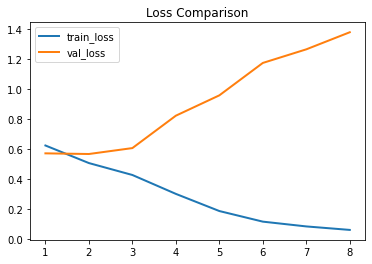

In [27]:
x_epochs = [1,2,3,4,5,6,7,8]
import matplotlib.pyplot as plt
plt.plot(x_epochs,losses,linewidth=2.0,label="train_loss")
plt.plot(x_epochs,losses_val,linewidth=2.0,label="val_loss")
plt.title("Loss Comparison")
plt.legend()

Text(0.5, 1.0, '0.0')

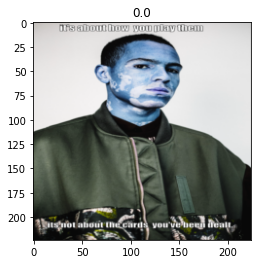

In [27]:
plt.imshow(np.transpose(img[0].detach().cpu().numpy(),(1,2,0)))
plt.title(label[0].item())